In [1]:
import numpy as np
import pandas as pd
import string
import math
import json
import pydotplus
from IPython.display import Image 

In [2]:
products = pd.read_csv('amazon_baby.csv')

## Perform Cleaning

In [3]:
def remove_punctuation(text):
    translator = text.maketrans('','',string.punctuation)
    return text.translate(translator)

In [4]:
products.review.fillna('',inplace=True)

In [5]:
products['review_clean'] = products['review'].apply(remove_punctuation)

## Extract Sentiments

In [6]:
products = products[products['rating'] != 3]

In [7]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

## Split into training and test sets

In [8]:
train_index = pd.read_json('module-9-assignment-train-idx.json')
train_index = list(train_index[0])

In [9]:
test_index = pd.read_json('module-9-assignment-test-idx.json')
test_index = list(test_index[0])

In [10]:
train_data = products.iloc[train_index]
test_data = products.iloc[test_index]

In [11]:
print('Training set: %d data points' % len(train_data))
print('Test set: %d data points' % len(test_data))

Training set: 133416 data points
Test set: 33336 data points


## Build the word count vector for each review

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
# Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

## Train a sentiment classifier with logistic regression

In [13]:
from sklearn import linear_model

In [14]:
logistic = linear_model.LogisticRegression()

In [15]:
model = logistic.fit(train_matrix, train_data['sentiment'])

## Model Evaluation

In [16]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'].as_matrix(), y_pred=model.predict(test_matrix))
print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.932265418766


## Baseline: Majority class prediction

In [17]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


## Confusion Matix

In [18]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].as_matrix(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   805
      1       |        1        | 27290


## Computing the cost of mistakes

In [19]:
#cost 
#false positives
print('cost of false positives =',1453*100)
print('cost of false negatives =',805*1)
print('total cost =$', 1453*100+805*1)

cost of false positives = 145300
cost of false negatives = 805
total cost =$ 146105


In [20]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].as_matrix(), 
                            y_pred=model.predict(test_matrix))
print("Precision on test data: %s" % precision)

Precision on test data: 0.949448561389


In [21]:
print('The false positive rate is:', 1-precision)

The false positive rate is: 0.0505514386111


In [22]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].as_matrix(),
                      y_pred=model.predict(test_matrix))
print("Recall on test data: %s" % recall)

Recall on test data: 0.971347214807


In [23]:
print(recall,'percent of positive reviews are correctly classified as positive')

0.971347214807 percent of positive reviews are correctly classified as positive


In [35]:
print('recall if all are predicted as positive would be:', test_data.sentiment.value_counts(normalize=True).values[0])

recall if all are predicted as positive would be: 0.842782577394


## Precision-recall tradeoff

In [219]:
probabilities = model.predict_proba(test_matrix)[:,1]

In [223]:
def apply_threshold(proba_array, threshold=0.5):
    ar = proba_array.copy()
    ar[ar>=threshold]=1
    ar[ar<threshold]=0
    return ar

In [229]:
output = apply_threshold(probabilities)
print('number of positive reviews at threshold of 0.5:',output[output==1].shape[0])

number of positive reviews at threshold of 0.5: 28743


In [230]:
output = apply_threshold(probabilities,0.9)
print('number of positive reviews at threshold of 0.9:', output[output==1].shape[0])

number of positive reviews at threshold of 0.9: 25070


## Exploring the associated precision and recall as the threshold varies

Compute precision and recall for thresholds at 0.5 and 0.9

In [233]:
print('Precision and Recall at 0.5 Threshold')

precision = precision_score(y_true=test_data['sentiment'].as_matrix(), y_pred=apply_threshold(probabilities))
recall = recall_score(y_true=test_data['sentiment'].as_matrix(),y_pred=apply_threshold(probabilities))
print("Recall on test data: %s" % recall)
print("Precision on test data: %s" % precision)

Precision and Recall at 0.5 Threshold
Recall on test data: 0.971347214807
Precision on test data: 0.949448561389


In [234]:
print('Precision and Recall at 0.9 Threshold')

precision = precision_score(y_true=test_data['sentiment'].as_matrix(), y_pred=apply_threshold(probabilities,0.9))
recall = recall_score(y_true=test_data['sentiment'].as_matrix(),y_pred=apply_threshold(probabilities,0.9))
print("Recall on test data: %s" % recall)
print("Precision on test data: %s" % precision)

Precision and Recall at 0.9 Threshold
Recall on test data: 0.875920982381
Precision on test data: 0.981611487834


Quiz Question (variant 1): Does the precision increase with a higher threshold?
 - Yes

Quiz Question (variant 2): Does the recall increase with a higher threshold?
 - No


## Precision-recall curve


In [236]:
threshold_values = np.linspace(0.5, 1, num=100)
print(threshold_values)

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

In [299]:
def recall_function(proba_array, threshold, data):
    ar = proba_array.copy()
    ar = apply_threshold(ar, threshold)
    from sklearn.metrics import recall_score
    recall = recall_score(y_true=data['sentiment'].as_matrix(),
                          y_pred=ar)
    return recall

def precision_function(proba_array, threshold, data):
    ar = proba_array.copy()
    ar = apply_threshold(ar, threshold)
    from sklearn.metrics import precision_score
    precision = precision_score(y_true=data['sentiment'].as_matrix(),
                                y_pred=ar)
    return precision

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

In [240]:
recall_all = [recall_function(probabilities, x, test_data) for x in threshold_values]
precision_all = [precision_function(probabilities, x, test_data) for x in threshold_values]

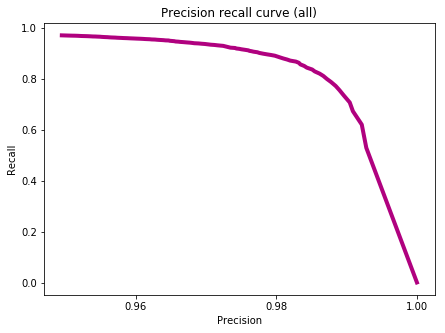

In [243]:
import matplotlib.pyplot as plt
%matplotlib inline
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

Quiz Question: Among all the threshold values tried, what is the smallest threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

Answer: 0.5757575757575758



In [246]:
list(zip(recall_all, threshold_values))

[(0.97134721480690511, 0.5),
 (0.97092009254315714, 0.50505050505050508),
 (0.97052856380138819, 0.51010101010101006),
 (0.97013703505961912, 0.51515151515151514),
 (0.96992347392774514, 0.52020202020202022),
 (0.96949635166399717, 0.5252525252525253),
 (0.9691048229222281, 0.53030303030303028),
 (0.96874888770243817, 0.53535353535353536),
 (0.9683217654386902, 0.54040404040404044),
 (0.96800142374087916, 0.54545454545454541),
 (0.96753870795515218, 0.5505050505050505),
 (0.96700480512546716, 0.55555555555555558),
 (0.96682683751557219, 0.56060606060606055),
 (0.96647090229578214, 0.56565656565656564),
 (0.96593699946609712, 0.57070707070707072),
 (0.96533190959245418, 0.5757575757575758),
 (0.96465563267485321, 0.58080808080808077),
 (0.96419291688912623, 0.58585858585858586),
 (0.96355223349350416, 0.59090909090909094),
 (0.96312511122975619, 0.59595959595959602),
 (0.96255561487809216, 0.60101010101010099),
 (0.96198611852642824, 0.60606060606060608),
 (0.96148780921872223, 0.611111

In [247]:
pd.DataFrame(list(zip(recall_all, threshold_values)))

,0,1
0,0.971347,0.500000
1,0.970920,0.505051
2,0.970529,0.510101
3,0.970137,0.515152
4,0.969923,0.520202
5,0.969496,0.525253
6,0.969105,0.530303
7,0.968749,0.535354
8,0.968322,0.540404
9,0.968001,0.545455


In [250]:
print(recall_function(probabilities,0.98))
print(precision_function(probabilities,0.98))

0.706495817761
0.990469061876


In [256]:
high_threshold = apply_threshold(probabilities, threshold=0.98)
high_threshold[high_threshold==1].shape[0]*(1-precision_function(probabilities, 0.98))

191.00000000000003

## Evaluating specific search terms


In [291]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in str(x).lower())]

In [294]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

In [295]:
threshold_values = np.linspace(0.5, 1, num=100)

In [300]:
recall_all = [recall_function(probabilities, x, baby_reviews) for x in threshold_values]
precision_all = [precision_function(probabilities, x, baby_reviews) for x in threshold_values]

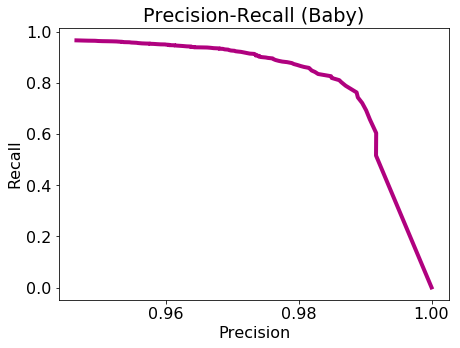

In [301]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")

In [302]:
list(zip(precision_all, threshold_values))

[(0.94646985594878175, 0.5),
 (0.94695621217515125, 0.50505050505050508),
 (0.94744343488330662, 0.51010101010101006),
 (0.94826048171275645, 0.51515151515151514),
 (0.9487591501517586, 0.52020202020202022),
 (0.94925853135608362, 0.5252525252525253),
 (0.94957081545064381, 0.53030303030303028),
 (0.94972266952943285, 0.53535353535353536),
 (0.95037620924399857, 0.54040404040404044),
 (0.95121076233183854, 0.54545454545454541),
 (0.95187645896929429, 0.5505050505050505),
 (0.95253505933117588, 0.55555555555555558),
 (0.95268933261377942, 0.56060606060606055),
 (0.95300684191573637, 0.56565656565656564),
 (0.95333333333333337, 0.57070707070707072),
 (0.95332492340962338, 0.5757575757575758),
 (0.95361848041869701, 0.58080808080808077),
 (0.95445508765588294, 0.58585858585858586),
 (0.95475113122171951, 0.59090909090909094),
 (0.95491580662683329, 0.59595959595959602),
 (0.95556764599202026, 0.60101010101010099),
 (0.95570884007986934, 0.60606060606060608),
 (0.95602398691622748, 0.61111

In [305]:
print(0.54040404040404044)
print('smaller')

0.5404040404040404
smaller
